# 데이터 다루기

## 10.1 데이터 탐색하기
모델을 만들어 해답을 찾기 전 가장 먼저 해야하는 일은 데이터를 탐색하는 것이다.

### 10.1.1 1차원 데이터 탐색하기
가장 간단한 경우는 단순히 숫자로만 구성된 1차원 데이터가 주어졌을 때이다. \
가장 먼저 **요약 통계치(summary statistics)**를 계산해야 한다. 데이터의 개수, 최솟값, 최댓값, 평균, 표준편차를 알아볼 필요가 있다. \
요약 통계치가 무의미한 경우, 범위를 몇 개의 구간으로 나누고 각 구간 안의 데이터 개수를 살펴보는 히스토그램을 만들자.

In [1]:
from typing import List, Dict
from collections import Counter
import math
import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """각 데이터를 bucket_size의 배수에 해당하는 구간에 위치시킨다."""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """구간을 생성하고 각 구간 안의 데이터 개수를 계산해 준다."""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [2]:
import random
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                      mu: float = 0,
                      sigma: float = 1,
                      tolerance: float = 0.00001) -> float:
    """이진 검색을 사용해 역함수를 근사"""
    # 표준정규분포가 아니라면 표준정규분포로 변환
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z = -10.0  # normal_cdf(-10)은 0에 근접
    hi_z = 10.0  # normal_cdf(10)은 1에 근접
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2  # 중간 값
        mid_p = normal_cdf(mid_z)  # 중간 값의 누적분포 값을 계산
        if mid_p < p:
            low_z = mid_z  # 중간 값이 너무 작다면 더 큰 값들을 검색
        else:
            hi_z = mid_z  # 중간 값이 너무 크다면 더 작은 값들을 검색
    
    return mid_z

In [3]:
random.seed(0)

# -100 ~ 100 사이의 균등분포
uniform = [200 * random.random() - 100 for _ in range(10000)]

# 평균이 0이고 표준편차가 57인 정규분포
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

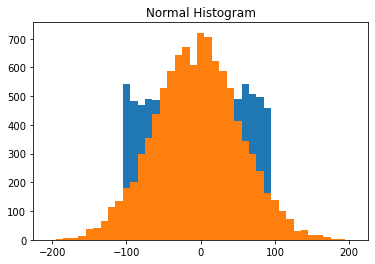

In [4]:
# 위의 두 데이터 모두 평균이 0이고 표준편차가 대략 58이지만 굉장히 다른 모양의 분포를 띈다.

plot_histogram(uniform, 10, "Uniform Historgram")
plot_histogram(normal, 10, "Normal Histogram")

두 분포의 최솟값과 최대값이 상당히 다르긴 하지만, 이것만으로도 두 분포의 차이를 이해하기는 쉽지 않다.

### 10.1.2 2차원 데이터
2차원 데이터가 주어졌다고 해보자. 사용자가 하루 평균 사이트에서 보내는 시간뿐 아니라 사용자의 데이터 과학 경력까지 주어졌다. \
아래와 같은 데이터가 주어졌다고 해보자

In [5]:
def random_normal() -> float:
    """표준 정규 분포를 따르는 임의의 데이터를 반환"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

ys1, ys2의 histogram은 비슷하다(평균과 표준편차가 동일하기 때문이다). xs에 대한 결합확률분포(joint distribution)의 모양은 상당히 다르다.

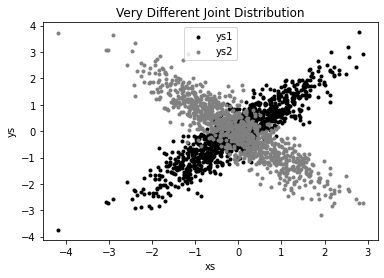

In [7]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distribution")
plt.show()

상관관계를 통해 차이를 확인할 수도 있다.

In [23]:
import math
from typing import List
from typing import Callable

Vector = List[float]
Matrix = List[List[float]]

def make_matrix(num_rows: int, num_cols: int, entry_fn: Callable[[int, int], float]) -> Matrix:
    """(i, j)번째 원소가 entry_fn(i, j)인 num_rows x num_cols 리스트를 반환"""
    return [[entry_fn(i, j) for j in range(num_cols)] for i in range(num_rows)]

def covariance(xs: List[float], ys: List[float]) -> float:
    assert len(xs) == len(ys),  "xs and ys must have same number of elements"
    return dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)

def dot(v: Vector, w: Vector) -> float:
    """v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w),  "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v: Vector) -> float:
    """v_1 * v_1 + ... v_n * v_n"""
    return dot(v,v)

def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

def de_mean(xs: List[float]) -> List[float]:
    """x의 모든 데이터 포인트에서 평균을 뺌(평균을 0으로 만들기 위해)"""
    x_bar = mean(xs)
    return [x - x_bar for x in xs]

def variance(xs: List[float]) -> float:
    """편차의 제곱의 평균"""
    assert len(xs) >= 2, "variance requires at least two elements"
    
    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(xs: List[float]) -> float:
    """표준편차는 분산의 제곱근"""
    return math.sqrt(variance(xs))

def correlation(xs: List[float], ys: List[float]) -> float:
    """xs와 ys의 값이 각각의 평균에서 얼마나 멀리 떨어져 있는지 계산"""
    stdev_x = standard_deviation(xs)
    stdev_y = standard_deviation(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs, ys) / stdev_x / stdev_y
    else:
        return 0  #  편차가 존재하지 않는다면 상관관계는 0

In [24]:
print(correlation(xs, ys1))
print(correlation(xs, ys2))

0.9010493686379609
-0.8920981526880033


### 10.1.3 다차원 데이터
다차원 데이터의 경우 각 차원이 서로 어떻게 연관되어 있는지 살펴볼 수 있다. 가장 간편한 방법은 상관관계 행렬을 살펴보는 것이다. 상관관계 행렬의 i번째 행과 j번째 열에 해당하는 값은 i번째 차원과 j번째 차원의 상관관계를 나타낸다.

In [25]:
def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    (i, j)번째 항목이 data[i]와 data[j]의 상관관계를 나타내는
    len(data) x len(data) 행렬을 반환함
    """
    def correlation_ij(i:int, j: int) -> float:
        return correlation(data[i], data[j])
    
    return make_matrix(len(data), len(data), correlation_ij)

만약, 차원은 수가 많지 않다면 **산포도 행렬(scatterplot matrix)**을 이용해서 각 차원의 쌍별로 산포도를 시각화할 수 있다. plt.subplots를 사용하면 차트 안에 하위 차트를 생성할 수 있다. plt.subplots에 행과 열을 입력하면 figure 객체와 2차원 axes 객체를 반환해 준다.

In [26]:
# corr_data는 100차원 벡터 네 개를 포함하고 있는 리스트다.
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        # x축은 j번째 열을, y축은 i번째 행을 나타내는 산포도
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])
        
        # 만약 i == j, series라는 제목 출력
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                               xycoords = "axes fraction",
                               ha="center", va="center")
        
        # 왼쪽과 밑에 위치한 치트에만 축 레이블 명시
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j

NameError: name 'corr_data' is not defined